In [20]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from mpl_toolkits import mplot3d

#from numba import njit, float64, vectorize


from csr2d.wake import green_mesh, boundary_convolve
#from csr2d.convolution import fftconvolve2

import time

#import concurrent.futures as cf

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

import warnings
warnings.filterwarnings('ignore')

In [61]:
# Chris's parameters 
gamma = 20000
rho = 1.0 # Bend radius in m

# Total charge
#Nb = 6.25e9
#Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

nz = 201
nx = 201
zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
Z, X = np.meshgrid(zvec, xvec, indexing='ij')
lambda_grid_filtered = lamb_2d(Z,X)
lambda_grid_filtered_prime = lamb_2d_prime(Z,X)
dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

In [62]:
Es_case_B_grid_IGF_no_break = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF',include_break_points=False)

In [63]:
Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')

In [64]:
#from mpl_toolkits import mplot3d
#Z, X = np.meshgrid(zvec, xvec, indexing="ij")

#fig, ax = plt.subplots(figsize=(8,8))
#ax = plt.axes(projection='3d')

#ax.plot_surface(Z,X, kaka2, cmap='inferno')
#ax.set_xlabel('z/2*rho')
#ax.set_ylabel('x/rho')
#ax.set_zlabel('psi_s')
#ax.set_title('psi_s at the first step of chicane')

## Ws(z) scan over $\phi$

In [65]:
#phi = 0.003
#z_observe = 0
x_observe = 0

def transient_calc_lambda_B_super_phi(phi):
    def transient_calc_lambda_B_super_z(z_observe):
        conv = boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF, gamma=gamma, rho=rho, phi=phi)
        factor_case_B = (beta**2 / rho**2) *(dx*dz)
        return factor_case_B*conv
    return np.array(list(map(transient_calc_lambda_B_super_z,zvec)))

def transient_calc_lambda_B_super_phi_no_break(phi):
    def transient_calc_lambda_B_super_z(z_observe):
        conv = boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF_no_break, gamma=gamma, rho=rho, phi=phi)
        factor_case_B = (beta**2 / rho**2) *(dx*dz)
        return factor_case_B*conv
    return np.array(list(map(transient_calc_lambda_B_super_z,zvec)))


phi_vec = [0.03, 0.04, 0.05, 0.07, 0.09, 0.12]

wake_list = list(map(transient_calc_lambda_B_super_phi, phi_vec))
wake_list_no_break = list(map(transient_calc_lambda_B_super_phi_no_break, phi_vec))

In [66]:
# 1D theory formulae

def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)

def plot_Ws_caseB_zi_term_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/phi/rho * lamb_1d( zvec - rho*phi**3/24), color = color, linewidth=4, label = label)
    
def plot_Wx_caseB_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/rho * lamb_1d( zvec ), color = color, linewidth=4, label = label)
    
from scipy import integrate

# Case B integral term ( for large phi this goes to the s-s wake )
def get_Wss(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

def get_Wzi(zo):
    return -4/phi/rho * lamb_1d( zo - rho*phi**3/24)

def get_Wtot(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return -4/phi/rho * lamb_1d( zo - rho*phi**3/24) + integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

In [67]:
phi = phi_vec[0]
Wss_list1 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[1]
Wss_list2 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[2]
Wss_list3 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[3]
Wss_list4 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[4]
Wss_list5 = np.array(list(map(get_Wtot, zvec)))
phi = phi_vec[5]
Wss_list6 = np.array(list(map(get_Wtot, zvec)))

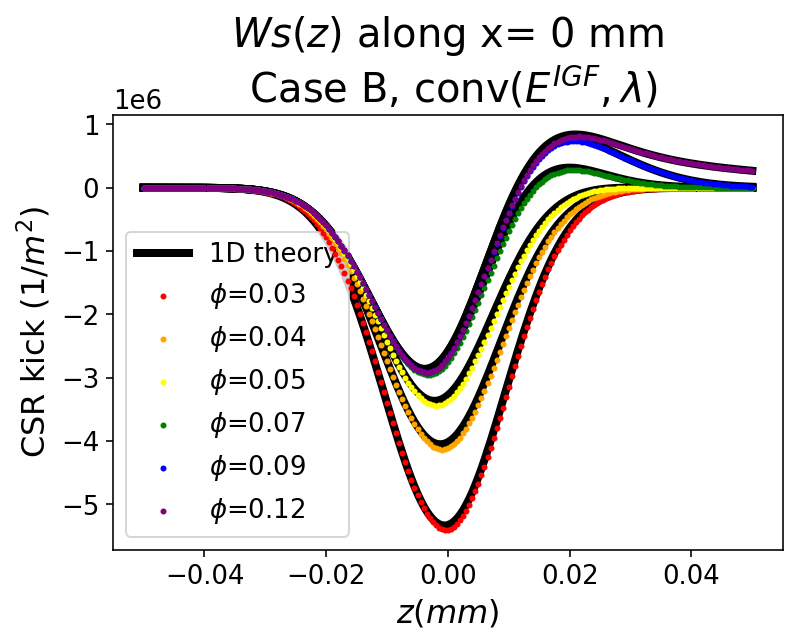

In [68]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = '1D theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('$z(mm)$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z)$ along x= {x_observe*1000} mm'+'\n Case B, conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='lower left')

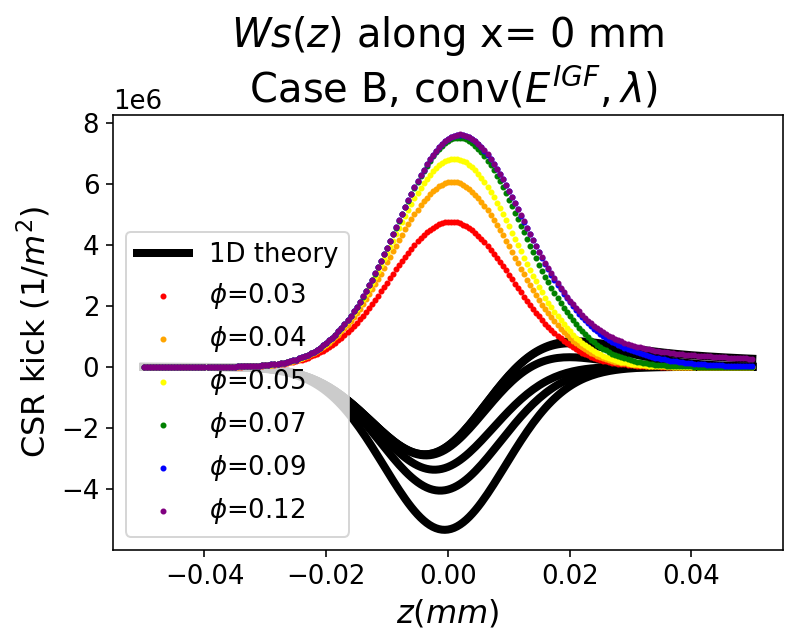

In [69]:
plt.scatter(zvec*10**3,wake_list_no_break[0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list_no_break[1], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_no_break[2], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_no_break[3], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_no_break[4], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list_no_break[5], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = '1D theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('$z(mm)$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z)$ along x= {x_observe*1000} mm'+'\n Case B, conv($E^{IGF},\lambda$)',  fontsize=20)
plt.legend(loc='lower left')

# Ws(0,0) scan over $\gamma$

In [71]:
phi = 0.05
z_observe = 0
x_observe = 0

Wss = get_Wtot(z_observe)

def transient_calc_lambda_B_super_gamma(gamma):
    Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')
    print(gamma, np.min(Es_case_B_grid_IGF))
    conv = boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF, gamma=gamma, rho=rho, phi=phi)
    factor_case_B = (beta**2 / rho**2) *(dx*dz)
    return factor_case_B*conv

def transient_calc_lambda_B_super_gamma_no_break(gamma):
    Es_case_B_grid_IGF_no_break = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF',include_break_points=False)
    conv = boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF_no_break, gamma=gamma, rho=rho, phi=phi)
    factor_case_B = (beta**2 / rho**2) *(dx*dz)
    return factor_case_B*conv

#gamma_vec = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]
gamma_vec = [500,2000,5000,10000,15000,20000]


gamma_vec = [1000, 2000, 3000, 4000,5000,6000,7000,8000,9000,10000]
gamma_vec = [11000,12000,13000,14000,15000,16000,17000,18000,19000,20000]
#wake_list = list(map(transient_calc_lambda_B_super_phi, phi_vec))

#wake_list_no_break = list(map(transient_calc_lambda_B_super_phi_no_break, phi_vec))

In [72]:
wake_list = list(map(transient_calc_lambda_B_super_gamma, gamma_vec))

11000 -2033148092.129907
12000 -2030311414.3185964
13000 -2028199677.8267674
14000 -2026506188.0897632
15000 -56925232460.6473
16000 -61288649674.86065
17000 -64814871935.43181
18000 -2022284730.290497
19000 -71650729302.64491
20000 -74936844876.3043


In [13]:
wake_list = list(map(transient_calc_lambda_B_super_gamma, gamma_vec))

11000 -3386650319.8395295
12000 -3382622424.1200843
13000 -3379656393.3860884
14000 -3377232523.469014
15000 -44999356813.513214
16000 -3373538330.1896615
17000 -3372401614.093745
18000 -3371264743.052119
19000 -3370264261.5059495
20000 -3368953473.5433717


In [73]:
wake_list_no_break = list(map(transient_calc_lambda_B_super_gamma_no_break, gamma_vec))

In [74]:
wake_1d_list = [Wss] * len(gamma_vec)

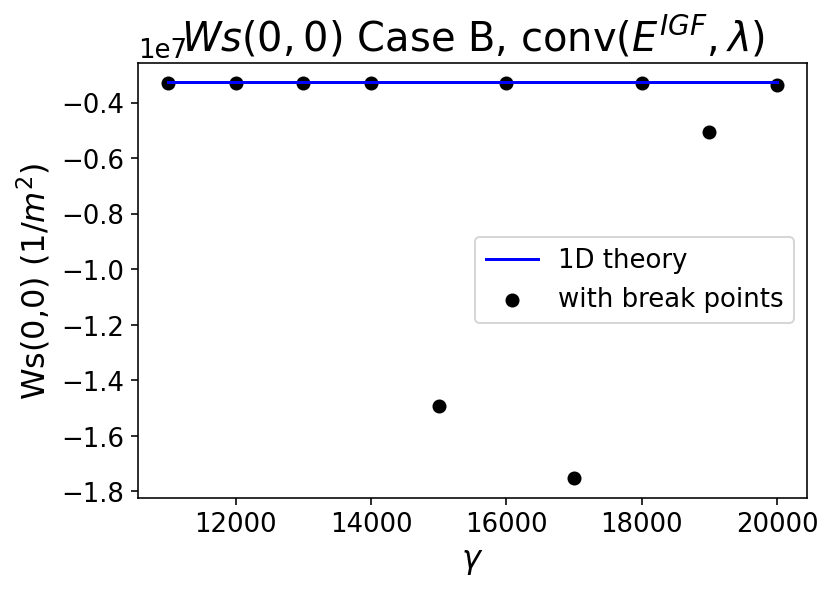

In [77]:
plt.scatter(gamma_vec, wake_list, label='with break points', color='black')
plt.plot(gamma_vec, wake_1d_list, label='1D theory', color='blue')
#plt.plot(gamma_vec, wake_list_no_break)

plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('Ws(0,0) $(1/m^2)$', fontsize=16)
plt.title(r'$Ws(0,0)$ Case B, conv($E^{IGF},\lambda$)', fontsize=20)
plt.legend(loc='lower left')
plt.legend(loc='center right')

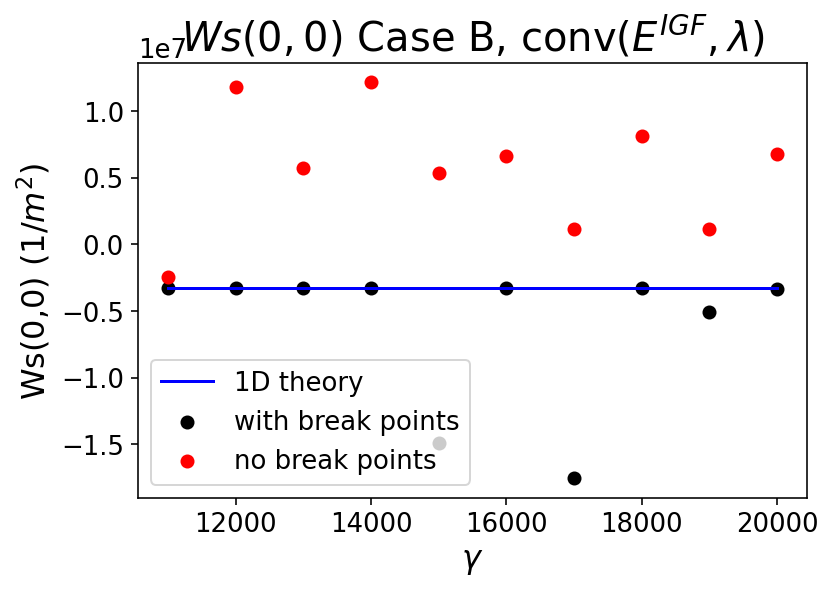

In [81]:
plt.scatter(gamma_vec, wake_list, label='with break points', color='black')
plt.plot(gamma_vec, wake_1d_list, label='1D theory', color='blue')
plt.scatter(gamma_vec, wake_list_no_break, label='no break points', color='red')

plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('Ws(0,0) $(1/m^2)$', fontsize=16)
plt.title(r'$Ws(0,0)$ Case B, conv($E^{IGF},\lambda$)', fontsize=20)
plt.legend(loc='lower left')

# Below is scratch

Text(0.5, 0.92, 'psi_s at the first step of chicane')

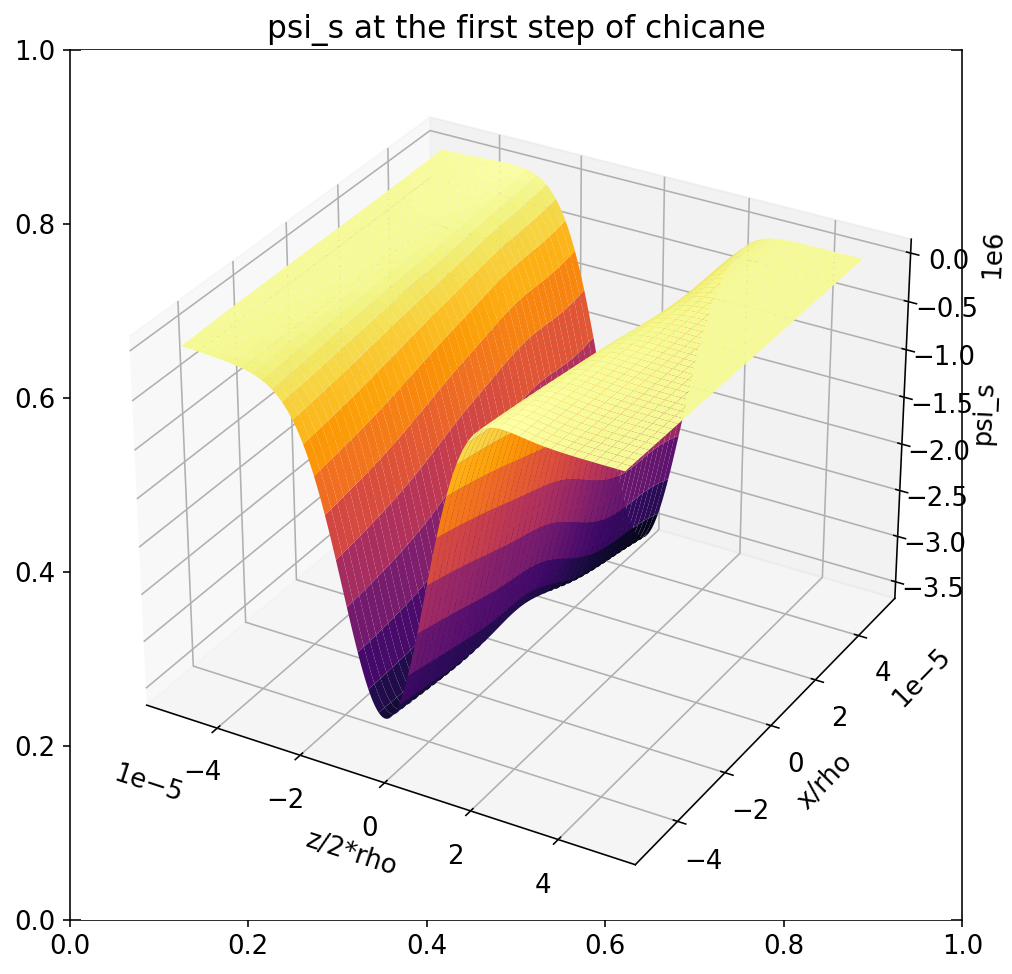

In [141]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z,X, kaka2, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

# Case B

In [ ]:
from csr2d.core2 import alpha_exact_case_B_brentq, Es_case_B
from numba import njit, vectorize, float64
from quantecon.optimize.root_finding import newton 

from scipy import optimize

from scipy.signal import find_peaks 

from scipy import integrate

In [ ]:
xval = sigma_x



In [ ]:
def Es_case_B_N2(z,x,gamma):
    
    beta2 = 1-1/gamma**2
    beta = np.sqrt(beta2)

    alp = alpha_exact_case_B_brentq(z, x, beta)
    
    sin2a = np.sin(2*alp)
    cos2a = np.cos(2*alp) 

    kap = (2*(alp - z))/beta # kappa for case B
    
    return (1+x)*sin2a - beta*kap

def Es_case_B_N2_z(z):
    return Es_case_B_N2(z,xval,gamma)

In [ ]:
optimize.root(Es_case_B_N2_z, -1E-9, tol=1E-9)

    fjac: array([[-1.]])
     fun: array([1.04083409e-17])
 message: 'The solution converged.'
    nfev: 41
     qtf: array([-1.12757026e-17])
       r: array([-178.73579931])
  status: 1
 success: True
       x: array([-1.49042991e-08])

In [ ]:
xvec;

In [20]:
def find_Es_case_B_spike(xval):
    """
    Return a list of z values at which Es_case_B(z,xval) has spikes
    """
    def Es_case_B_N2_z(z):
        return Es_case_B_N2(z,xval,gamma)
    
    # First find where N2 ~ 0, and we are close to spike(s)
    op = optimize.root(Es_case_B_N2_z, 0, tol=1E-6)
    if op.success == False:
        #print('no N2 root found!!')
        return [0]
    
    root = op.x[0]

    def Es_case_B_z(z):
        return Es_case_B(z, xval, gamma)
    
    zv = np.linspace( root - 2E-11, root + 2E-11, 2001 ) # The range and resolution are subjected to changes...
    peak_ix = np.union1d(find_peaks( Es_case_B_z(zv))[0], find_peaks( -Es_case_B_z(zv))[0])
    
    return list(zv[peak_ix])
    

Text(0.5, 1.0, 'Es(z) along x = 1.0000000000000002e-06')

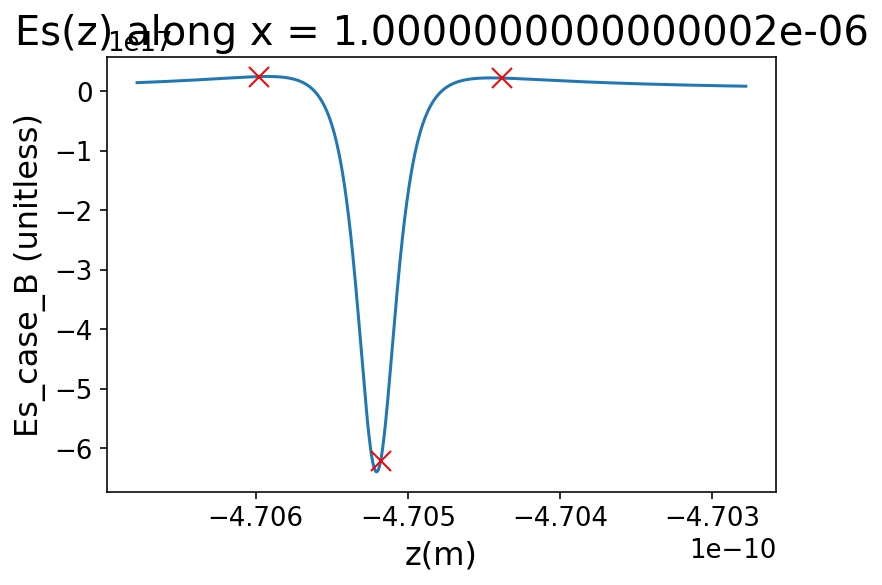

In [23]:
xval = 0.1*sigma_x

def Es_case_B_z(z):
    return Es_case_B(z, xval, gamma)* beta**2/rho**2

def Es_case_B_N2_z(z):
    return Es_case_B_N2(z,xval,gamma)

z_N2_0 = optimize.root(Es_case_B_N2_z, 0, tol=1E-6).x[0]
zv = np.linspace( z_N2_0-2E-13, z_N2_0+ 2E-13, 4001)
#zv = np.linspace( z_N2_0-2E-9, z_N2_0+ 2E-9, 4001)

plt.plot(zv, Es_case_B_z(zv))
#plt.plot(zv[peak_ix], Es_case_D_z(zv)[peak_ix], "x", c='red', markersize=10)

z_spike = find_Es_case_B_spike(xval)

plt.plot(z_spike, Es_case_B_z(z_spike), "x", c='red', markersize=10)

plt.xlabel('z(m)', fontsize=16)
plt.ylabel('Es_case_B (unitless)', fontsize=16)
plt.title(f'Es(z) along x = {xval}',  fontsize=20)

In [53]:
optimize.root(Es_case_B_N2_z, 0, tol=1E-6)

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 3
     qtf: array([0.])
       r: array([5.99697561])
  status: 1
 success: True
       x: array([0.])

In [67]:
z_spike

[-4.70597929855314e-10, -4.70517929855314e-10, -4.704379298553141e-10]

In [76]:
z_obeserve = 0

xval = 0.1*sigma_x

def Es_case_B_z(z):
    return Es_case_B(z, xval, gamma)* beta**2/rho**2

integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = [z_obeserve]+[1000], epsrel=1e-6, limit=50)

/tmp/ipykernel_38578/864499250.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = [z_obeserve]+[1000], epsrel=1e-6, limit=50)


(3448.8739245793454, 31.412219208880288)

In [74]:
points

[0, -4.70597929855314e-10, -4.70517929855314e-10, -4.704379298553141e-10]

In [75]:
points = [z_obeserve]+find_Es_case_B_spike(xval)
integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = points, epsrel=1e-6, limit=50)

/tmp/ipykernel_38578/2941820721.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(Es_case_B_z, z_obeserve-dz/2, z_obeserve+dz/2, points = points, epsrel=1e-6, limit=50)


(-88.03908272082896, 0.08735536272700994)

In [4]:
Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')

TypeError: find_Es_case_B_spike() missing 1 required positional argument: 'gamma'

In [13]:
Es_case_B_grid_IGF_no_break = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF',include_break_points=False)

/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]
/global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py:223: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, z-dz/2, z+dz/2, points = points, epsrel=1e-6, limit=100)[0]
